In [1]:

%pip install geopandas
%pip install pycountry

import geopandas as gpd
import igraph as ig
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point
import shapely
import os
import pandas as pd
import pycountry
import matplotlib.pyplot as plt


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [113]:
# clean 
def iso3_to_country_name(iso3_code):
    try:
        country = pycountry.countries.get(alpha_2=iso3_code)
        if country:
            return country.name
        else:
            return "Country not found"
    except AttributeError:
        return "Country not found"



# Create a subfolder if it doesn't exist
dir_path = "EGM_2019_SHP_20190312/DATA/Countries"

files = os.listdir(dir_path)
countries_string = (sorted(files))[1:] + ['EU']
subfolder_path = 'output'
os.makedirs(subfolder_path, exist_ok=True)



for name in countries_string[:3]:
    empty_geometry = gpd.GeoDataFrame()
    empty_geometry['geometry'] = 'nan'
    empty_geometry['ICC'] = 'nan'

    nodes_return = pd.DataFrame()
    edges_return = pd.DataFrame()

    base_path = 'EGM_2019_SHP_20190312/DATA/Countries/' + name + '/'

    if name == 'EU':
        base_path = 'EGM_2019_SHP_20190312/DATA/FullEurope/'

    rails_path = base_path + 'RailrdL.shp'
    stations_path = base_path + 'RailrdC.shp'
    country_code_path = base_path + 'CountryCodes.dbf'
    levelcc_path = base_path + 'LevelcC.shp'
    aircc_path = base_path + 'AirfldP.shp'
    ferrycc_path = base_path + 'FerryC.shp'
    restcc_path = base_path + 'RestC.shp'
    intercc_path = base_path + 'RestC.shp'
    
    if os.path.exists(rails_path):
        rails = gpd.read_file(rails_path)
        print(f'Loaded {rails_path}')
    
        
        if os.path.exists(stations_path):
            stations = gpd.read_file(stations_path)
            print(f'Loaded {stations_path}')
        else:
            stations = empty_geometry.copy()
        
        if os.path.exists(country_code_path):
            country_code = gpd.read_file(country_code_path)
            print(f'Loaded {country_code_path}')
        else:
            country_code = empty_geometry.copy()
        
        if os.path.exists(levelcc_path):
            levelcc = gpd.read_file(levelcc_path)
            print(f'Loaded {levelcc_path}')
        else:
            levelcc = empty_geometry.copy()
        
        if os.path.exists(aircc_path):
            aircc = gpd.read_file(aircc_path)
            print(f'Loaded {aircc_path}')
        else:
            aircc = empty_geometry.copy()
        
        if os.path.exists(ferrycc_path):
            ferrycc = gpd.read_file(ferrycc_path)
            print(f'Loaded {ferrycc_path}')
        else:
            ferrycc = empty_geometry.copy()
        
        if os.path.exists(restcc_path):
            restcc = gpd.read_file(restcc_path)
            print(f'Loaded {restcc_path}')
        else:
            restcc = empty_geometry.copy()
        
        if os.path.exists(intercc_path):
            intercc = gpd.read_file(intercc_path)
            print(f'Loaded {intercc_path}')
        else:
            intercc = empty_geometry.copy()



        geolines = rails['geometry']
        rails['locs_from'] = shapely.get_point(rails.geometry, 0)
        rails['locs_to'] = shapely.get_point(rails.geometry, -1)


        check1 = pd.DataFrame()
        check2= pd.DataFrame()

        check1[['locations','country_ISO3', 'LLE' ]] = rails[['locs_from', 'ICC', 'LLE']]
        check2[['locations','country_ISO3', 'LLE' ]] = rails[['locs_to', 'ICC', 'LLE']]    
        nodes_return = pd.concat([check1, check2], ignore_index=True)



        # naming the stations
        matching_nodes = nodes_return['locations'].isin(stations['geometry'])
        nodes_return.loc[matching_nodes, 'nodeLabels'] = "station"

        # labeling the levelcrossings
        matching_nodes = nodes_return['locations'].isin(levelcc['geometry'])
        nodes_return.loc[matching_nodes, 'nodeLabels'] = "levelcrossing"

        # labeling the airports
        matching_nodes = nodes_return['locations'].isin(aircc['geometry'])
        nodes_return.loc[matching_nodes, 'nodeLabels'] = "airport"

        # labeling the ferries
        matching_nodes = nodes_return['locations'].isin(ferrycc['geometry'])
        nodes_return.loc[matching_nodes, 'nodeLabels'] = "ferry"

        # labeling the rest places
        matching_nodes = nodes_return['locations'].isin(restcc['geometry'])
        nodes_return.loc[matching_nodes, 'nodeLabels'] = "rest"

        # labeling the interchange
        matching_nodes = nodes_return['locations'].isin(intercc['geometry'])
        nodes_return.loc[matching_nodes, 'nodeLabels'] = "interchange"

        # Assuming nodes_return is your DataFrame
        nodes_return["nodeLabels"].fillna('unknown')

# _____________________________________







        edges_return = rails[['locs_from', 'locs_to', 'LLE']]
        nodes_return = nodes_return.drop_duplicates()

        # Convert columns to strings and normalize the string values to ensure consistency


        # Creating a mapping from location and LLE to nodeID
        nodes_return["nodeID"] = np.arange(len(nodes_return))
        coord_LLE_to_index = {(row['locations'], row['LLE']): row['nodeID'] for _, row in nodes_return.iterrows()}

        # Mapping nodeID_from and nodeID_to in edges_return
        edges_return['nodeID_from'] = edges_return.apply(lambda row: coord_LLE_to_index.get((row['locs_from'], row['LLE'])), axis=1)
        edges_return['nodeID_to'] = edges_return.apply(lambda row: coord_LLE_to_index.get((row['locs_to'], row['LLE'])), axis=1)

        
        # selecting the locations that occur twice
        counts = nodes_return['locations'].value_counts()
        doubles = nodes_return[nodes_return['locations'].isin(counts[counts == 2].index)]
        
        # deselecting nodes that occur twice but have same LLE
        doubles = doubles.drop_duplicates(subset = ['locations','LLE'])
        #print(doubles)


        # this way, same locs are grouped together
        doubles_sorted = doubles.sort_values(by='locations')

        node_ids_doubled = list(doubles_sorted['nodeID'])

        #create dict so that same nodes have same id
        dict_2_to_1 = dict()

        for i in range(0, len(node_ids_doubled),2):
            From = node_ids_doubled[i]
            To =  node_ids_doubled[i+1]
            dict_2_to_1[From] = To
        
        # apply on the lists,


        edges_return['nodeID_from'] = edges_return['nodeID_from'].map(dict_2_to_1).fillna(edges_return['nodeID_from'])
        edges_return['nodeID_to'] = edges_return['nodeID_to'].map(dict_2_to_1).fillna(edges_return['nodeID_to'])


        # node_ids to throw away
        throw_away = list(dict_2_to_1.keys())
        nodes_return = nodes_return[~ nodes_return['nodeID'].isin(throw_away)]

          
        # Extract the old node IDs
        old_ids = list(nodes_return['nodeID'])

        # Create a mapping dictionary from old IDs to new IDs
        dict_old_new_id = {old_id: new_id for new_id, old_id in enumerate(old_ids)}


        edges_return['nodeID_from'] = edges_return['nodeID_from'].map(dict_old_new_id)
        edges_return['nodeID_to'] = edges_return['nodeID_to'].map(dict_old_new_id)
        nodes_return['nodeID'] = nodes_return['nodeID'].map(dict_old_new_id)

    


        # creating the lon/lat columns
        locs = gpd.GeoDataFrame(nodes_return, geometry='locations')
        lon = locs['locations'].x
        lat = locs['locations'].y

        nodes_return["longetude"] = lon
        nodes_return["latitude"] = lat

        nodes_return['country_name'] = nodes_return['country_ISO3'].apply(iso3_to_country_name)

        # filtering the data
        nodes = nodes_return[["nodeID", "nodeLabels", "latitude", 'longetude', 'country_name', 'country_ISO3' ]].copy()
        edges = edges_return[["nodeID_from", "nodeID_to"]].copy()


        nodes.to_csv(os.path.join(subfolder_path, 'nodes_'+name+'.csv'), index=False)
        edges.to_csv(os.path.join(subfolder_path, 'edges_'+name+'.csv'), index=False)
    else:
        # Assign empty GeoDataFrame with 'geometry' column
        
        nodes_return.to_csv(os.path.join(subfolder_path, 'nodes_'+name+'.csv'), index=False)
        edges_return.to_csv(os.path.join(subfolder_path, 'edges_'+name+'.csv'), index=False)

/tmp/ipykernel_593/2073938947.py:26: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  empty_geometry['geometry'] = 'nan'
/tmp/ipykernel_593/2073938947.py:26: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  empty_geometry['geometry'] = 'n

Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/RailrdL.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/RailrdC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/CountryCodes.dbf
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/LevelcC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/AirfldP.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/RestC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/RestC.shp


/home/jules/.var/app/com.vscodium.codium/data/python/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/jules/.var/app/com.vscodium.codium/data/python/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/jules/.var/app/com.vscodium.codium/data/python/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCop

Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/RailrdL.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/RailrdC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/CountryCodes.dbf
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/LevelcC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/AirfldP.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/FerryC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/RestC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/RestC.shp


/home/jules/.var/app/com.vscodium.codium/data/python/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/jules/.var/app/com.vscodium.codium/data/python/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/jules/.var/app/com.vscodium.codium/data/python/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCop

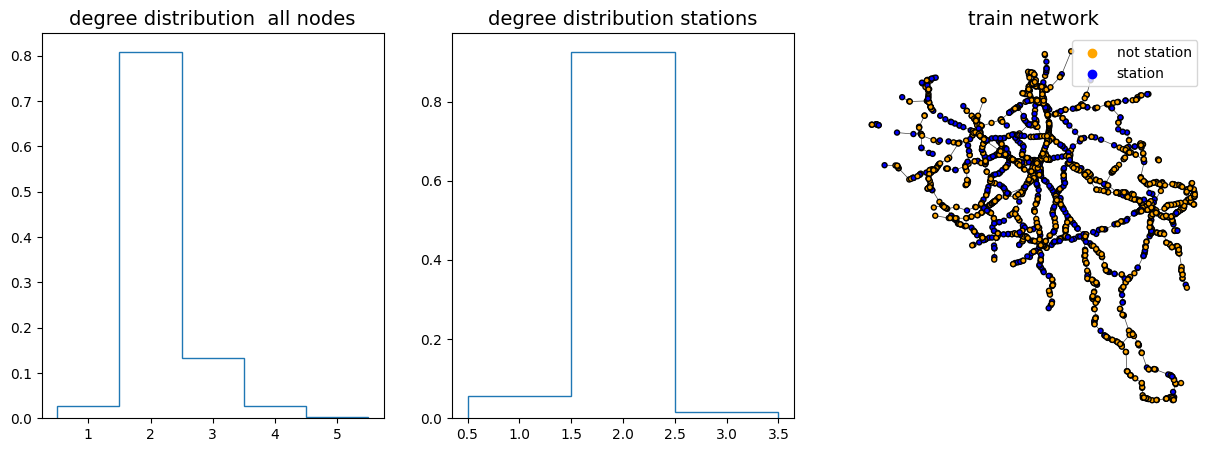

In [116]:
def get_info_country(land_code):
    edges = pd.read_csv('output/edges_'+land_code+'.csv')
    nodes = pd.read_csv(('output/nodes_'+land_code+'.csv'))

    g = ig.Graph.DataFrame(edges, directed=False, vertices=nodes)
    
    g.vs['nodeLabel'] = nodes['nodeLabels']
    degree_full = g.degree()
    stations = g.vs.select(nodeLabel='station')
    degree_station = stations.degree()

    vertex_color = list(g.vs['nodeLabel'])
    vertex_color = ['blue' if item == 'station' else 'orange' for item in vertex_color]
    vertex_size = g.vs['nodeLabel']
    vertex_size = [3 if item == 'station' else 1 for item in vertex_size]
    lay = list(zip(g.vs['longetude'],np.array(g.vs['latitude'])))

    fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))


    counts, bins = np.histogram(degree_full, bins = np.arange(0,max(degree_full)+1)+0.5, density = True)
    ax[0].stairs(counts, bins)
    ax[0].set_title('degree distribution  all nodes', fontsize = 14)

    counts, bins = np.histogram(degree_station, bins = np.arange(0,max(degree_station)+1)+0.5, density = True)
    ax[1].stairs(counts, bins)
    ax[1].set_title('degree distribution stations', fontsize = 14)

    ax[2].set_yticks([])
    ax[2].set_xticks([])

    ax[2].scatter([],[], color = "orange", label = 'not station')
    ax[2].scatter([],[], color = "blue", label = 'station')
    ax[2].set_title('train network', fontsize = 14)

    ax[2].set_xlim([np.min(g.vs['longetude'])-0.1,np.max(g.vs['longetude']) + 0.1])
    ax[2].set_ylim([np.min(g.vs['latitude'])-0.1,np.max(g.vs['latitude'])+0.1])
    



    ig.plot(g, 
    layout = lay,
    vertex_size= 5, vertex_color = list(vertex_color), edge_width = 0.5, target =ax[2])

    plt.legend()
    plt.show()

get_info_country('BE')

In [ ]:
land_code = 'BE'

edges = pd.read_csv('output/edges_'+land_code+'.csv')
nodes = pd.read_csv(('output/nodes_'+land_code+'.csv'))

from collections import Counter
check = (list(nodes['longetude']) + list(nodes['latitude']))
c = Counter(check)
count_occurrence_points = Counter(c.values())
print(' occurence of points:', count_occurrence_points)
print(c)

 occurence of points: Counter({2: 2039, 1: 1933, 3: 7, 4: 1})
Counter({50.74901249999985: 4, 4.416939999999784: 3, 4.423021499999805: 3, 4.419629999999785: 3, 50.90104649999984: 3, 50.90123149999985: 3, 50.90115599999984: 3, 50.55889599999984: 3, 3.7071644999998057: 2, 3.2405264999997883: 2, 6.036399999999787: 2, 3.9826279999998064: 2, 3.1310724999997888: 2, 3.137431499999792: 2, 3.687311499999794: 2, 3.6842724999997927: 2, 5.586864499999791: 2, 4.422945499999798: 2, 4.421655499999787: 2, 3.678013999999792: 2, 4.405281499999802: 2, 3.247311999999795: 2, 3.1297984999997936: 2, 5.460555499999799: 2, 3.442874499999789: 2, 3.4504129999997986: 2, 3.1940634999998: 2, 3.006790499999795: 2, 3.204620999999804: 2, 3.1885754999997857: 2, 3.981754499999795: 2, 3.976016499999787: 2, 3.105933999999792: 2, 3.1067269999998075: 2, 5.828471999999806: 2, 5.845128999999787: 2, 5.847026999999798: 2, 3.257544499999796: 2, 3.6013044999997987: 2, 4.6083519999997975: 2, 3.229254499999797: 2, 3.2349894999997844

In [ ]:
 occurence of points: Counter({2: 2039, 1: 1933, 3: 7, 4: 1})